In this notebook I am exploring different ways of working with image deformations as displacement fields, the way they are represented in MONAI's registration components.

In [1]:
import sys

In [2]:
import monai
import torch
from utils import plot_2D_vector_field, plot_2D_deformation
import math
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def get_example_ddf(s_x, s_y=None, variant=0):
    """Get an example DDF (direct displacement field).
    Arguments:
        s_x, s_y: The x and y scale. Provide s_x only to have them be the same scale.
            "Scale" here really means "resolution." Think of it as the same underlying displacement,
            but meant to be applied to images at different resolutions.
        variant: integer selector for which variant of example to return.
    """
    if s_y is None:
        s_y=s_x
    if variant==0:
        ddf = torch.tensor(
            [[
                [(s_y/32)*math.sin(2*math.pi*(y/s_y) * 3),(s_x/32)*2*math.cos(2*math.pi* (x/s_x) * 2)]
                for x in range(s_x)]
                for y in range(s_y)
            ]
        ).permute((2,0,1))
    elif variant==1:
        ddf = torch.tensor(
            [[
                [(s_y/32)*math.sin(2*math.pi*(x/s_x) * 3),(s_x/32)*2*math.cos(2*math.pi* (y/s_y) * 2)]
                for x in range(s_x)]
                for y in range(s_y)
            ]
        ).permute((2,0,1))
    else:
        raise ValueError(f"There is no variant {variant}")
    return ddf

In [4]:
scale = 128

load_image = monai.transforms.Compose([
    monai.transforms.LoadImage(image_only=True, reader='pilreader', dtype=np.float32),
    monai.transforms.ScaleIntensityRange(0,255,0,1),
    monai.transforms.Transpose((2,1,0)),
    monai.transforms.Flip(0), # This is so I can plot images with origin='lower', to prevent some confusing things
    monai.transforms.Resize((scale,scale)),
    monai.transforms.ToTensor()
])

img_path = '/home/ebrahim/Pictures/pumpkin_face_autumn_october.jpg' # can put any image here

img = load_image(img_path)

# function to show image assuming it was in the (channels, height, width) format.
def plt_image(img, title=None):
    plt.imshow(np.transpose(img,axes=(1,2,0)),origin='lower')
    if title is not None:
        plt.title(title)
    plt.show()

In [5]:
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="border")

# function that is just like warp except it doesn't work with batch dimension
apply_warp = lambda img,ddf : warp(img.unsqueeze(0), ddf.unsqueeze(0))[0]

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


Let $\Omega$ denote the image domain, so that for example a grayscale image is a map $\Omega\to\mathbb{R}$.

Deformations $\phi:\Omega\to\Omega$ act upon images like this:
$$
I.\phi = I\circ \Phi
$$
Note that this is a _right_ action. This is important to keep in mind in order to get composition in the correct order later on.

# How not to compute the inverse of a displacement field

Suppose $\phi$ is the deformation $x\mapsto x+u(x)$. Here $u(x)$ can be though of as a displacement field, so one might think that $-u(x)$ leads to a reasonable approximate inverse. But it's actually quite bad where the deformation has a sizable derivative. Let's think about how the displacement field for the inverse of $\phi$ is actually related to the dispalcement field for $\phi$.

Let $\bar{u}(y)$ be the displacement field for $\phi^{-1}$; i.e. $\bar{u}(y)$ is such that $\phi^{-1}$ maps $y$  to $y+\bar{u}(y)$. Then

$$x = \phi^{-1}(\phi(x)) = \phi^{-1}(x+u(x)) = x+u(x)+\bar{u}(x+u(x)) $$

$$y = \phi(\phi^{-1}(y)) = \phi^{-1}(y+\bar{u}(y)) = y+\bar{u}(y)+u(y+\bar{u}(y)) $$

so

$$ \bar{u}(x+u(x)) = -u(x) $$
$$ \bar{u}(y) = -u(y+\bar{u}(y)) $$

or in other words

$$ \bar{u}.\phi=-u$$
$$ \bar{u}=-u.\phi^{-1}$$

You can't get $\bar{u}$ without already having a way to apply $\phi^{-1}$, which is nontrivial for arbitrary invertible $\phi$.

## Demo of negative displacement failing to work

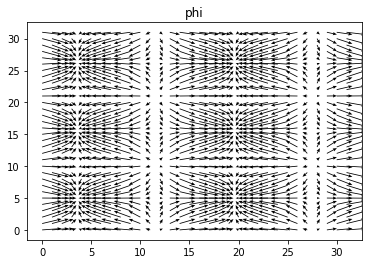

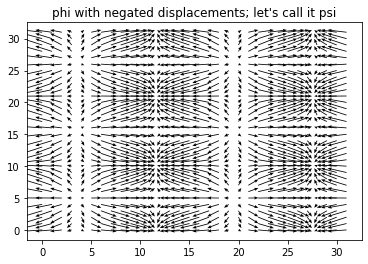

In [6]:
strength = 1

u = strength*get_example_ddf(scale, variant=0) 
ub = -u # a bad attempt at approximating the inverse of phi

plot_2D_vector_field(u, 4)
plt.title('phi')
plt.show()
plot_2D_vector_field(ub, 4)
plt.title('phi with negated displacements; let\'s call it psi')
plt.show()

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


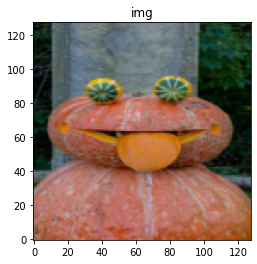

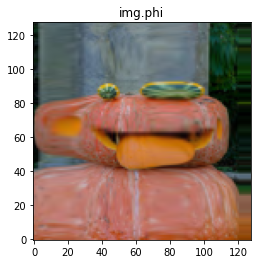

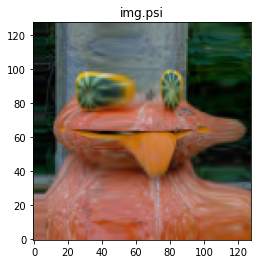

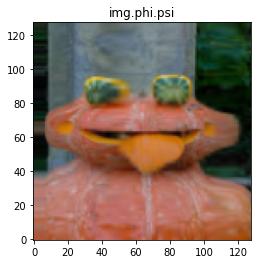

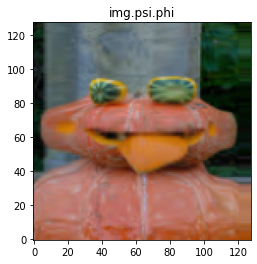

In [7]:
img1 = apply_warp(img,u)
img2 = apply_warp(img,ub)
img3 = apply_warp(img1,ub)
img4 = apply_warp(img2,u)
plt_image(img,"img")
plt_image(img1,"img.phi")
plt_image(img2,"img.psi")
plt_image(img3,"img.phi.psi")
plt_image(img4,"img.psi.phi")

The last two images should look like the first image, perhaps with some loss. But they look warped, because, as discussed above, negating the displacement field doesn't work to produce an inverse.

# How to compose two displacement fields

Say $\phi(x)=x+u(x)$ and $\psi(y)=y+v(y)$. Then 
$$\psi(\phi(x)) = x+u(x)+v(x+u(x))$$
so the displacement field for $\psi\circ \phi$ is
$$u(x)+v(x+u(x))$$
or in other words
$$u+v.\phi$$
The displacement field $v$ is just a kind of image, where the channels are vector components. So we can compute $\phi.v$ using the same method that we use to warp images.

Potential source of confusion: Acting on an image by $\psi\circ\phi$ first applies the deformation $\psi$ and then applies the deformation $\phi$. This is because deforming images is a _right_ action. This is confusing, because thinking of $\psi\circ\phi$ as a function $\Omega\to\Omega$ usually means you are thinking about how it acts on points, which is a left action and should be interpreted in the "$\phi$ then $\psi$" order.

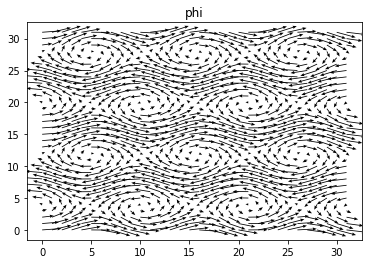

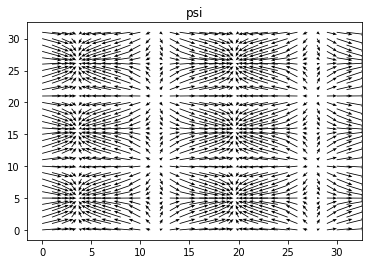

In [8]:
strength = 1

u = strength*get_example_ddf(scale, variant=1) 
v = strength*get_example_ddf(scale, variant=0) 

plot_2D_vector_field(u, 4)
plt.title('phi')
plt.show()
plot_2D_vector_field(v, 4)
plt.title('psi')
plt.show()

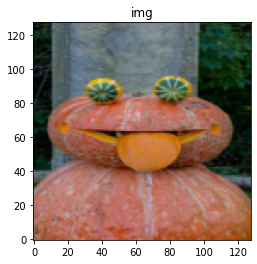

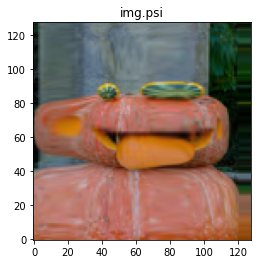

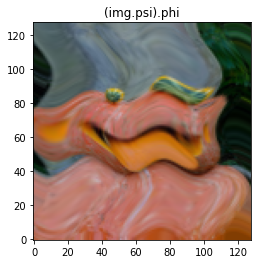

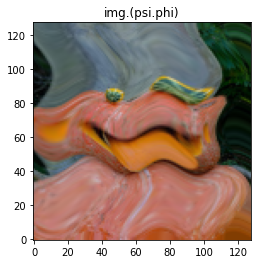

In [9]:
plt_image(img,"img")
plt_image(apply_warp(img,v),"img.psi")
plt_image(apply_warp(apply_warp(img,v),u),"(img.psi).phi")
w = u+apply_warp(v,u)
plt_image(apply_warp(img,w),"img.(psi.phi)")

The fact that the last two images look the same is a good verification of the suggested technique for displacement field composition:
```
w = u + warp(v,u)
```
This is the way to create a displacement field for the deformation that first warps via displacement `v` and then warps via displacement `u`.

For fun, here's a view of the composite displacement field:

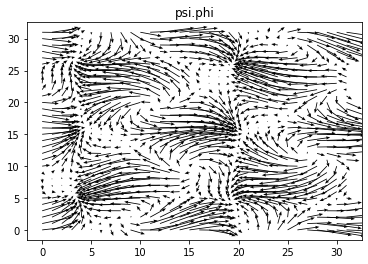

In [10]:
plot_2D_vector_field(w, 4)
plt.title("psi.phi")
plt.show()

# Examine effects on grids

I found some subtle errors in my original implementations of `plot_2D_deformation` and `plot_2D_vector_field`, and the investigation here helped me to fix them.

This following deformation picture used to be wrong in two ways (e.g. back at the time of [this commit](https://github.com/ebrahimebrahim/deep-atlas/tree/dc0132120d939f37f6b382f7c47ee1dc6abd9eb3)):
1. The function `plot_2D_deformation` plots the wrong direction of deformation action, showing the inverse of the deformation we want to show. This is because applying a deformation to coordinate paths $[0,1]\to\Omega$ is the opposite of applying the formation to coordinate functions $\Omega\to\mathbb{R}$.
1. The function `plot_2D_deformation` was flipping x and y components somewhere.

It should be correct now:

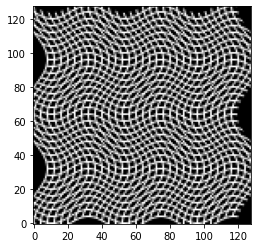

In [11]:
plot_2D_deformation(u,4)

## Make a grid and right-act upon it by displacement field

(Nothing much valuable in this subsection; I was just looking at different ways of making a grid image to visualize warp)

In [12]:
vector_field = v
grid_spacing = 4 # must be int

spatial_dims, height, width = vector_field.shape
assert(spatial_dims==2)


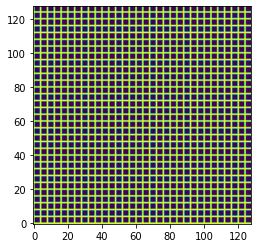

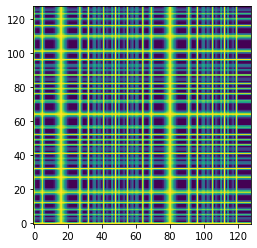

In [13]:
img = np.zeros((height, width))
img[np.arange(0, height, grid_spacing),:]=1
img[:,np.arange(0, width, grid_spacing)]=1
img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
plt_image(img)
warped_img = apply_warp(img, vector_field)
plt_image(warped_img)

## Kind of reimplement MONAI warp to make sure it's doing what I think

(Nothing much valuable in this subsection; just checking something for myself)

In [14]:
grid_sample = torch.nn.functional.grid_sample

In [15]:
input = img.unsqueeze(0)

identity_phi = torch.stack(torch.meshgrid(torch.linspace(0,height-1,height), torch.linspace(0,width-1,width)))
phi = identity_phi + vector_field
phi_normalized = ((phi/torch.tensor([height,width]).reshape((2,1,1)))*2-1)
grid = phi_normalized.permute((1,2,0)).unsqueeze(0)

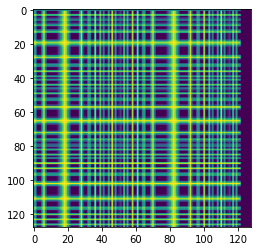

In [16]:
out = grid_sample(input, grid, align_corners=False, mode='bilinear')

plt.imshow(out[0,0])
plt.show()

Yes, it is definitely doing what I thought.

## More checks

(Nothing much valuable in this subsection; I was looking more into the effect of warping to make sure the way it works matches the mathematical description in my notes.)

In [ ]:
# the image here is such that there is a bijection between pixel values and locations
img = np.array([[height*x+y for y in range(height)] for x in range(width)])
img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
plt_image(img)
warped_img = apply_warp(img, v)
plt_image(warped_img)

In [18]:
y=100
x=50
yp, xp = torch.tensor([y,x]) + v[:,y,x]

print(yp.item(), xp.item())
print(
    img[0,int(yp),int(xp)].item(),
    img[0,int(yp)+1,int(xp)].item(),
    img[0,int(yp),int(xp)+1].item(),
    img[0,int(yp)+1,int(xp)+1].item(),
)
print(warped_img[0,y,x].item())

103.32588195800781 51.56072235107422
13235.0 13363.0 13236.0 13364.0
13277.2734375


As I try different points here, it does seem to do the right thing.

Trying another warp on the grid:

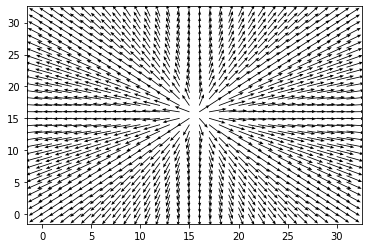

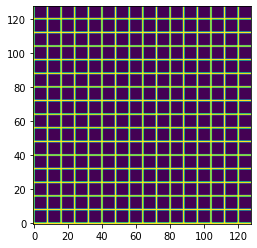

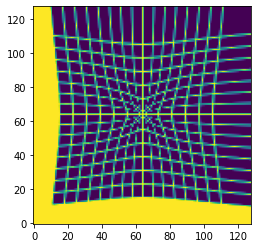

In [19]:
v = 15*torch.tensor(
    [[
        [
            (2*(x/width)-1)  / (0.00001 + math.sqrt((2*(y/height)-1)**2 + (2*(x/width)-1)**2)),
            (2*(y/height)-1) / (0.00001 + math.sqrt((2*(y/height)-1)**2 + (2*(x/width)-1)**2))
        ]
        for y in range(height)]
        for x in range(width)
    ]
).permute((2,0,1))
plot_2D_vector_field(0.5*v,4) # plotting the vector field at half strength, so rotational symmetry is clear
plt.show()

grid_spacing=8
img = np.zeros((height, width))
img[np.arange(0, height, grid_spacing),:]=1
img[:,np.arange(0, width, grid_spacing)]=1
img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
plt_image(img)
warped_img = apply_warp(img, v)
plt_image(warped_img)

Here is another visual. Replace the rotation matrix below by any 2x2 matrix you want to see how the monai warp applies that transform to the image. (If you are tracking structures in the image, applying the transform means applying the _inverse_ to the points making up those structures)

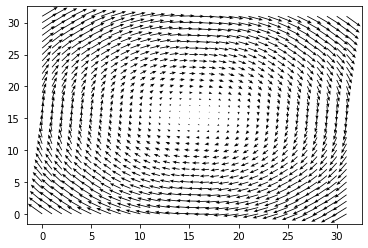

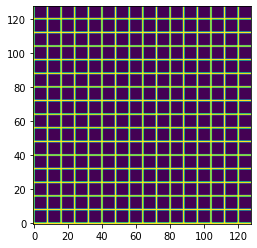

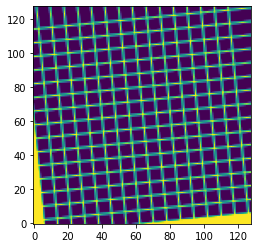

In [20]:
identity_phi = torch.stack(torch.meshgrid(torch.linspace(0,height-1,height), torch.linspace(0,width-1,width)))
theta = math.pi/32
phi = identity_phi-64
phi = np.einsum('ij,jkl',
    # Put any matrix transform you want to apply here to observe how warp applies it
    np.array([[math.cos(theta), -math.sin(theta)],[math.sin(theta), math.cos(theta)]]),
    phi,
)
phi = phi+64
v = torch.tensor(phi, dtype=torch.float32) - identity_phi
plot_2D_vector_field(v,4)
plt.show()

img = np.zeros((height, width))
img[np.arange(0, height, grid_spacing),:]=1
img[:,np.arange(0, width, grid_spacing)]=1
img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
plt_image(img)
warped_img = apply_warp(img, v)
plt_image(warped_img)

## How imshow vs quiver order their axes
This has been causing some confusion; just looking at some examples answered a lot of questions for me.

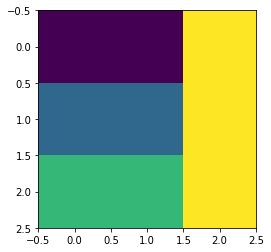

In [21]:
U = np.array([
    [1,1,4],
    [2,2,4],
    [3,3,4]
])
plt.imshow(U)

This is row,column order. The 0 axis points down and the 1 axis points right.

Or the 0 axis can point up and the 1 axis right:

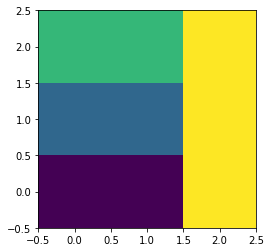

In [22]:
plt.imshow(U, origin='lower')

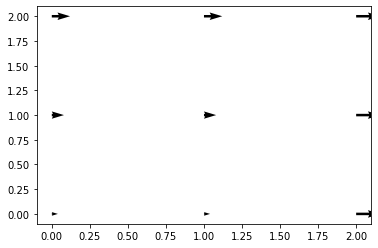

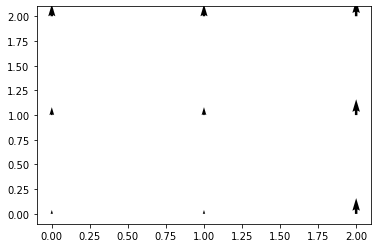

In [23]:
U = 0.04*np.array([
    [1,1,4],
    [2,2,4],
    [3,3,4]
])
V=np.zeros((3,3))
plt.quiver(U,V, angles='xy', scale_units='xy', scale=1)
plt.show()
plt.quiver(V,U, angles='xy', scale_units='xy', scale=1)
plt.show()

Let's say the origin is at the lower left with the x axis pointing right and the y axis pointing up.

The first and second arguments of `quiver` are the vector field components as arrays indexed over 2D space.
- The first arg of `quiver` is the rightward component of the vectors, the x component.
- The second arg of `quiver` is the upward component of the vectors, the y component.

The 0 axis of each of U and V points up, while the 1 axis points to the right. So these arrays are indexed over space in y,x order.

To summarize:

Say you have a vector field with components x_component and y_component. Then you have to index it over space such that the value at location $(x,y)$ is (`x_component[y,x]`,`y_component[y,x]`), and then you can plot it properly with `plt.quiver(x_component, y_component)`.

And if you have an image `img` that you want to display in the same coordinate system, then it has to be indexed such that the pixel value at location $(x,y)$ is `img[y,x]` and you have to use `plt.imshow(img, origin='lower')`.